In [78]:
import hyperspace

In [79]:
import hyperspace
from getpass import getpass


hyperspace_client = hyperspace.HyperspaceClientApi(host="",username="",password="")

In [80]:
collection_name = 'new_collection'

hyperspace_client.delete_collection(collection_name)


{'code': 200, 'message': 'Collection was successfully deleted', 'status': 'OK'}

In [81]:
if collection_name not in hyperspace_client.collections_info()['collections']:
    hyperspace_client.create_collection('imagesearch_config.json', collection_name)

In [82]:
import os
if not os.path.exists("EmbedAnything"):
  !git clone https://github.com/StarlightSearch/EmbedAnything.git

In [83]:
#import libs
import embed_anything
import numpy as np
from PIL import Image



In [84]:
# change whole directory "train" from images to embeddings
data = embed_anything.embed_directory("train", embeder= "Clip")
embeddings = [data.embedding for data in data]

In [133]:
# get metadata/ filenames of each image
import os


folder_path = 'train'
subfolders = ['pizza', 'steak', 'sushi']

filenames = []

for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.exists(subfolder_path):
        subfolder_files = os.listdir(subfolder_path)
        filenames.extend([os.path.join(subfolder, file) for file in subfolder_files])

print(filenames)

['pizza\\1008844.jpg', 'pizza\\1033251.jpg', 'pizza\\1044789.jpg', 'pizza\\1089334.jpg', 'pizza\\1105700.jpg', 'pizza\\12301.jpg', 'pizza\\1285298.jpg', 'pizza\\138855.jpg', 'pizza\\1412034.jpg', 'pizza\\1524655.jpg', 'pizza\\1572608.jpg', 'pizza\\1633289.jpg', 'pizza\\1649276.jpg', 'pizza\\1654444.jpg', 'pizza\\1660415.jpg', 'pizza\\1899785.jpg', 'pizza\\1947572.jpg', 'pizza\\1968947.jpg', 'pizza\\2026009.jpg', 'pizza\\2121603.jpg', 'pizza\\2154394.jpg', 'pizza\\218711.jpg', 'pizza\\2190018.jpg', 'pizza\\220190.jpg', 'pizza\\2228322.jpg', 'pizza\\2285942.jpg', 'pizza\\2291093.jpg', 'pizza\\2330965.jpg', 'pizza\\2382016.jpg', 'pizza\\2426686.jpg', 'pizza\\2428085.jpg', 'pizza\\244505.jpg', 'pizza\\2451169.jpg', 'pizza\\2493954.jpg', 'pizza\\2569760.jpg', 'pizza\\2576168.jpg', 'pizza\\2687575.jpg', 'pizza\\2702825.jpg', 'pizza\\2760984.jpg', 'pizza\\2785084.jpg', 'pizza\\2800325.jpg', 'pizza\\2811032.jpg', 'pizza\\2821048.jpg', 'pizza\\2885050.jpg', 'pizza\\2885796.jpg', 'pizza\\2924941

In [86]:
import pandas as pd
data_df = pd.DataFrame({'id': range(1, len(embeddings)+1),  'img_clip': embeddings, 'metadata': filenames})
data_df

,id,img_clip,metadata
0,1,"[0.13327446579933167, 0.3664315342903137, -0.0...",pizza\1008844.jpg
1,2,"[0.24338793754577637, -0.021096978336572647, -...",pizza\1033251.jpg
2,3,"[-0.052621662616729736, 0.10028950870037079, -...",pizza\1044789.jpg
3,4,"[0.31674355268478394, 0.07275772839784622, -0....",pizza\1089334.jpg
4,5,"[-0.20853638648986816, 0.11809525638818741, 0....",pizza\1105700.jpg
...,...,...,...
220,221,"[-0.4488583207130432, 0.025142855942249298, -0...",sushi\840444.jpg
221,222,"[-0.05791804939508438, 0.1334383487701416, -0....",sushi\843815.jpg
222,223,"[0.11123035848140717, 0.2789187729358673, 0.11...",sushi\855721.jpg
223,224,"[-0.5359077453613281, 0.0890749841928482, -0.0...",sushi\929471.jpg


In [87]:
# ADD it to batches of hyperspace

import math

BATCH_SIZE = 5


def normalize_euclidean_norm(input_list):
    if abs(sum(input_list)) < 0.0000000000000001:
        return input_list
    euclidean_norm = math.sqrt(sum(x ** 2 for x in input_list))
    if euclidean_norm == 0:
        return input_list
    normalized_list = [x / euclidean_norm for x in input_list]
    return normalized_list

batch = []

for i, ((_, data_df_row), embedding) in enumerate(zip(data_df.iterrows(), embeddings)):
    row = {}
    row['id'] = str(data_df_row['id'])
    row['img_clip'] = data_df_row['img_clip']
    row['metadata'] = data_df_row['metadata']
    batch.append(row)
    if i % BATCH_SIZE == 0:
        try:
            response = hyperspace_client.add_batch(batch, collection_name)

        except:
            display(batch)
            break
        batch.clear()


hyperspace_client.commit(collection_name)

{'code': 200, 'message': 'Dataset committed successfully', 'status': 'OK'}

In [139]:
embed_image = embed_anything.embed_directory("test/steak", embeder= "Clip") 

In [142]:
results = hyperspace_client.search(
   {'params': {'img_clip': embed_image[0].embedding}, 'knn': [{'field': 'img_clip', "boost": 1}]},
   size=10,
   collection_name=collection_name)



In [143]:
for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    print(result['metadata'])

148 === 91.81782531738281
steak\75537.jpg
145 === 91.37800598144531
steak\482022.jpg
74 === 90.25360870361328
pizza\764429.jpg
112 === 90.15901947021484
steak\231296.jpg
152 === 89.9462661743164
steak\937133.jpg
140 === 89.57368469238281
steak\3727491.jpg
100 === 89.52176666259766
steak\1966300.jpg
99 === 89.42878723144531
steak\1961025.jpg
102 === 88.92054748535156
steak\2013535.jpg
84 === 88.84954833984375
steak\1413972.jpg


In [144]:
top_k = 4
top_k_results = []

for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    result = hyperspace_client.get_document(collection_name, res['document_id'])
    top_k_results.append(result['metadata'])
    print(result)

148 === 91.81782531738281
{'id': '148', 'img_clip': [-0.20605190098285675, 0.17190077900886536, -0.1000330001115799, 0.12157934904098511, 0.46716809272766113, -0.29523760080337524, -0.6154910326004028, -0.5662958025932312, 0.40435731410980225, -0.029279425740242004, -0.044503353536129, -0.4514934718608856, 0.3461570739746094, 0.27513203024864197, 0.5267260074615479, -0.11079716682434082, 1.4621881246566772, -0.37919583916664124, 0.39074277877807617, -0.4481455683708191, -1.4095942974090576, 0.1952393352985382, 0.28143948316574097, -0.05386243015527725, -0.10772791504859924, -0.7550501227378845, 0.13255921006202698, -0.07124486565589905, 0.1500459611415863, 0.0715026929974556, 0.1337699294090271, -0.10471595823764801, 0.2391517609357834, 0.31243517994880676, 0.8802666664123535, 0.2808840572834015, -0.15635964274406433, -0.20474354922771454, -0.4574308395385742, 1.353722333908081, -0.7052872180938721, -0.16979363560676575, 0.20132094621658325, -0.0512419156730175, 0.1863730251789093, -1.

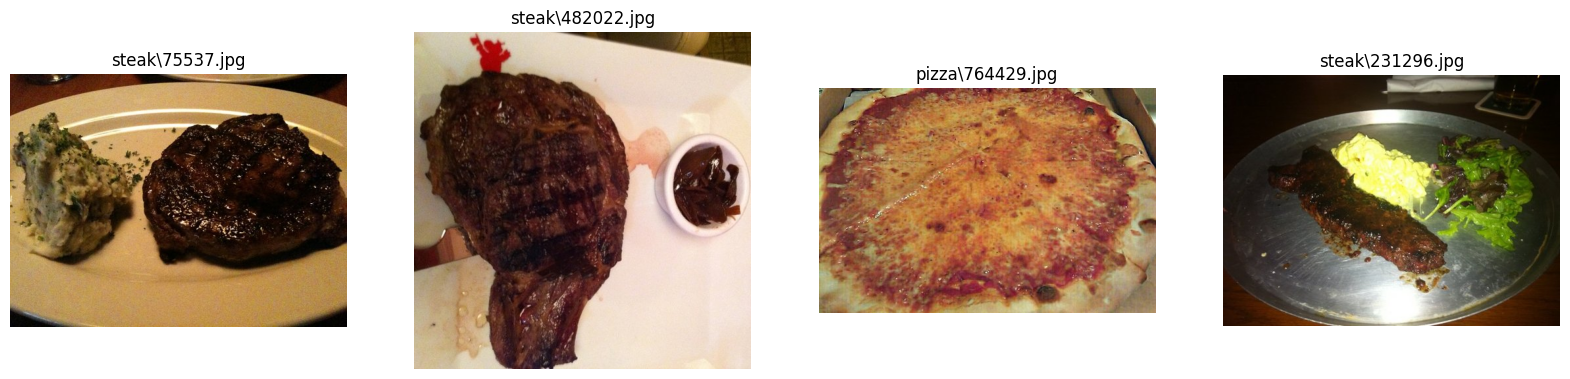

In [145]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, min(top_k, len(top_k_results)), figsize=(20, 20))
for i, file in enumerate(top_k_results[:min(top_k, len(top_k_results))]):
    img = Image.open(os.path.join('train', file))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(file)